# KNN optimisation

Exercice présent <a href="http://exercices.openclassrooms.com/assessment/628" target="_blank">ici</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

%matplotlib inline

Chargeons et visualisons rapidement le dataset

In [2]:
dataset = pd.read_csv("winequality-white.csv", sep=";")

In [3]:
print(dataset.head(), "\n")
print(dataset.describe(), "\n")
print(dataset.info())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

On a un dataset clean, tout est en type float, il ne manque rien donc c'est parfait. On peut donc recuperer les labels ainsi que les données d'entrées

In [4]:
y = dataset["quality"]
X = dataset.drop("quality", axis=1)

Comme on va travailler sur le KNN, il faut scale les features. Pour cela on peut utiliser soit le MinMaxScaler soit le StandardScaler. Partons sur le standard Scaler

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Voila nos données sont étalonnées, on peut mainteant decouper notre dataset en un training set et test set. Mais avant ca il faut melanger le dataset car il est ordonné par qualité ascendante.

In [6]:
X, y = shuffle(X, y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Maintenant on peut commencer par une approche naïve pour avoir une baseline

# Evaluation sur des approche naïves

### Retourner classe aléatoire

Avant de retourner betement un random, regardons la répartition des qualités sur le dataset complet. On sait que la qualité sera un entier entre 3 et 9 donc on peut afficher un histogramme de 7 bins

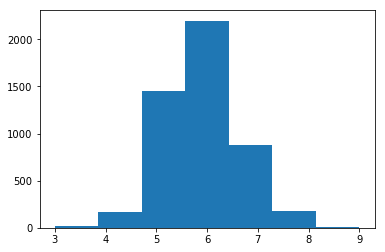

In [8]:
plt.hist(y, bins=7)
plt.show()

Hum la repartition semble suivre la lois normale avec une moyenne et un StDev données precedemment (cf l'exploration du dataset). Creons donc un classifieur random suivant cette repartition mais ce coup ci de la taille du test_set car on peut tester ca sur le set de test (NB: On pourrait le faire sur le full dataset car il n'y a aucun training, cependant on evaluera par la suite le resultat sur le test_set)

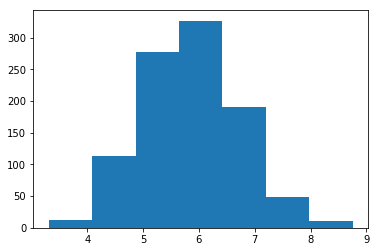

In [9]:
y_random = np.random.normal(y.mean(), y.std(), size=y_test.shape)
plt.hist(y_random, bins=7)
plt.show()

In [10]:
MSE = mean_squared_error(y_test, y_random)
print(MSE)

1.47023087281


Hum... un MSE de 1.54, c'est pas bon sachant qu'entre avg et min/max on a 3 (6=>9 et 6=>3). Bien qu'on ait essayé de modéliser la répartion au mieux, on est completement à coté. On peut aussi afficher sa prediction vs la realite.

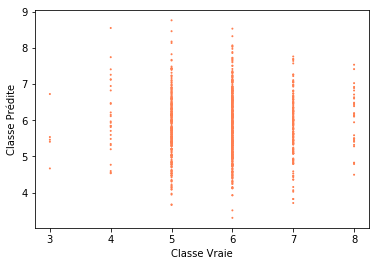

In [11]:
sizes = {}
for (yt, yp) in zip(list(y_test), list(y_random)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter([k[0] for k in keys], [k[1] for k in keys], s=[sizes[k] for k in keys], color='coral')
plt.xlabel("Classe Vraie")
plt.ylabel("Classe Prédite")
plt.show()

On remarque que la repartition est très "éclaté" car on a souvent beaucoup faux et parfois de bcp (predire 4 quand c'est 8 par exemple)

# Mise en place d'un modèle optimisé

Sachant qu'on a qu'un seul paramètre, on peut faire entrainer le modèle en faisant une loop sur le nb de voisins et evaluer le MSE manuellement. On verra le gridsearch ensuite

In [12]:
for i in range(1, 20):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    print("{} voisins - MSE = {}".format(i, MSE))

1 voisins - MSE = 0.6051020408163266
2 voisins - MSE = 0.5160714285714286
3 voisins - MSE = 0.5082766439909296
4 voisins - MSE = 0.4986607142857143
5 voisins - MSE = 0.4795102040816327
6 voisins - MSE = 0.4901927437641723
7 voisins - MSE = 0.4946064139941691
8 voisins - MSE = 0.4948660714285714
9 voisins - MSE = 0.4997228521038045
10 voisins - MSE = 0.4980102040816326
11 voisins - MSE = 0.49848203744307634
12 voisins - MSE = 0.4957482993197279
13 voisins - MSE = 0.49586402608380636
14 voisins - MSE = 0.5008954602249063
15 voisins - MSE = 0.5041904761904762
16 voisins - MSE = 0.5065768494897959
17 voisins - MSE = 0.5105253866252383
18 voisins - MSE = 0.5086514235323759
19 voisins - MSE = 0.5120357284187914


Un MSE a 0.479 dans le meilleur des cas (5 voisins), c'est bien mieux. On remarque que le modèle a bien "appris". Cependant on test toujours sur le meme test_set qui est peut etre plus difficile qu'un autre. Cela sera corrigé par la suite avec un split en Kfold

Affichons maintenant la prediction vs la realité

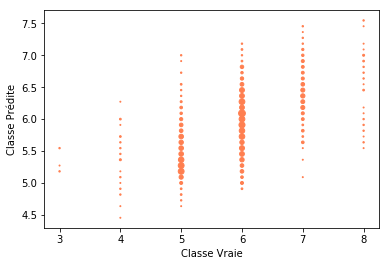

In [13]:
best_param = 11       # meilleur parametre lors du test
knn = KNeighborsRegressor(n_neighbors=best_param)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

sizes = {}
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter([k[0] for k in keys], [k[1] for k in keys], s=[sizes[k] for k in keys], color='coral')
plt.xlabel("Classe Vraie")
plt.ylabel("Classe Prédite")
plt.show()

On peut remarquer que l'éclatement de la prédiction est plus "propre". On est rarement très loin de la réalité (max +/- 1 environ)

On peut aussi utiliser le GridSearch qui lui fonctionne avec le K-fold. En plus de tester le modèle sur tout le dataset (en decoupant le set en n-partie), cette outil permet aussi de recuperer le meilleur modèle deje entrainée. Attention l'evaluation est faite sur le MSE mais négatif (implémenté avec Skelarnn 0.18). Ca donne le meme resultat mais en négatif. On affichera donc son opposé

In [14]:
knn = KNeighborsRegressor()

voisins = list(range(1, 20))
param_grid = [{"n_neighbors": voisins}]
grid_search = GridSearchCV(knn, param_grid=param_grid ,cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X, y)  # le dataset complet car on a le K-fold

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Comme fait précédemment on peut afficher le resultat en fonction des paramètres. Comme expliqué ci dessus on affichera -score au lieu du score car sklearn le calcul negativement

In [15]:
evaluation = grid_search.cv_results_
for score, param in zip(evaluation["mean_test_score"], evaluation["params"]):
    print(-score, param)

0.607594936709 {'n_neighbors': 1}
0.544507962434 {'n_neighbors': 2}
0.532552969466 {'n_neighbors': 3}
0.525099530421 {'n_neighbors': 4}
0.516153532054 {'n_neighbors': 5}
0.50647089515 {'n_neighbors': 6}
0.504887459271 {'n_neighbors': 7}
0.502367037566 {'n_neighbors': 8}
0.502545760678 {'n_neighbors': 9}
0.50323397305 {'n_neighbors': 10}
0.502063584732 {'n_neighbors': 11}
0.503484982533 {'n_neighbors': 12}
0.506762813466 {'n_neighbors': 13}
0.507129107257 {'n_neighbors': 14}
0.508183839209 {'n_neighbors': 15}
0.508626767303 {'n_neighbors': 16}
0.510185641763 {'n_neighbors': 17}
0.510995291603 {'n_neighbors': 18}
0.511867017913 {'n_neighbors': 19}


Comme prévu, on a plus ou moins les mêmes résultats. L'avantage du grid_search est d'voir acces directement au meilleur modèle et deja fit.

Regardons du coté d'une evaluation avec r^2. On refait comme precedemment en changeant juste le scoring

In [16]:
grid_search2 = GridSearchCV(knn, param_grid=param_grid ,cv=5, scoring="r2")
grid_search2.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [17]:
evaluation = grid_search2.cv_results_
for score, param in zip(evaluation["mean_test_score"], evaluation["params"]):
    print(score, param)

0.223133682098 {'n_neighbors': 1}
0.304318993296 {'n_neighbors': 2}
0.319474875834 {'n_neighbors': 3}
0.32895718941 {'n_neighbors': 4}
0.340175116519 {'n_neighbors': 5}
0.352704570138 {'n_neighbors': 6}
0.354779271477 {'n_neighbors': 7}
0.357996750168 {'n_neighbors': 8}
0.35769031469 {'n_neighbors': 9}
0.356877078161 {'n_neighbors': 10}
0.358352001569 {'n_neighbors': 11}
0.356619976019 {'n_neighbors': 12}
0.352490770679 {'n_neighbors': 13}
0.351993466478 {'n_neighbors': 14}
0.350710726095 {'n_neighbors': 15}
0.350196897638 {'n_neighbors': 16}
0.348245236544 {'n_neighbors': 17}
0.347174112581 {'n_neighbors': 18}
0.346054656406 {'n_neighbors': 19}


On remarque que le r^2 est très mauvais entre 0.25 et 0.35. Cette evaluation est vraiment pas bonne pour ce type d'exercice. Elle est plutot fait pour evaluer des regressions linéaires

# Selection du modèle Final

On peut donc recupérer le meilleur modèle du 1er grid_search. Pour le comparer à notre tout premier modèle fait avec le split, on peut tester aussi ce modèle sur le test_set (bien que l'on sache qu'on aura plus ou moin). 

In [18]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print("MSE = {}".format(MSE))

MSE = 0.3963568898633834


Bizarrement, sur ce test_set, on remarque que le MSE est tout de même plus bas que sur la moyenne fait par le grid search. C'est probablement de la chance (l'entrainement du grid search sur ce modèle a peut etre été fait sur un set assez similaire au test set du départ. 